In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datetime import date 
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
%matplotlib inline 
import spacy

In [2]:
pd.options.display.max_columns = 600

df=pd.read_csv('airbnb_data_cleaned.csv')

In [3]:
df.head()

,neighborhood_overview,transit,access,interaction,house_rules,host_id,host_since,host_location,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,name_describe_host
0,0,1,1,1,1,2758,2008-09-06,In NY,within a few hours,0.70,1,3.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",1,1,Harlem,Manhattan,10026.0,40.799205,-73.953676,1,Apartment,Private room,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",59.0,0.0,60.0,2,39.0,2,21,today,3,12,23,298,175,93.0,9.0,9.0,10.0,9.0,9.0,9.0,0,strict_14_with_grace_period,0,0,1.42,Stay at Chez Chic budget room #1 Step into our...
1,1,1,1,1,1,42032,2009-09-29,In NY,within a day,0.80,0,1.0,"['email', 'phone', 'reviews', 'kba']",1,1,Upper West Side,Manhattan,10025.0,40.797642,-73.961775,1,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",140.0,0.0,40.0,2,28.0,5,365,yesterday,8,8,13,248,76,94.0,10.0,9.0,10.0,10.0,10.0,10.0,0,moderate,1,1,0.72,Light-filled classic Central Park An adorable...
2,1,1,0,0,1,2787,2008-09-07,In NY,within an hour,1.00,1,8.0,"['email', 'phone', 'reviews', 'kba']",1,1,Kensington,Brooklyn,11218.0,40.647486,-73.972370,0,Apartment,Private room,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Wheelchair acces...",149.0,100.0,25.0,1,25.0,1,730,today,30,60,90,365,9,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0,moderate,0,0,0.25,Clean & quiet apt home by the park Renovated a...
3,1,1,1,1,1,2845,2008-09-09,In NY,within a few hours,0.82,0,5.0,"['email', 'phone', 'reviews', 'kba', 'work_ema...",1,1,Midtown,Manhattan,10018.0,40.753621,-73.983774,0,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",225.0,350.0,100.0,2,0.0,1,1125,3 days ago,15,45,75,350,41,95.0,9.0,9.0,10.0,10.0,10.0,9.0,0,strict_14_with_grace_period,1,1,0.37,Skylit Midtown Castle Find your romantic getaw...
4,1,1,1,1,1,82685,2010-02-18,In NY,did not respond,0.00,0,1.0,"['email', 'phone', 'google', 'reviews', 'jumio...",1,1,Harlem,Manhattan,10031.0,40.828028,-73.947308,1,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,E...",89.0,100.0,30.0,1,55.0,1,60,29 months ago,30,60,90,365,1,100.0,10.0,10.0,10.0,10.0,10.0,8.0,0,strict_14_with_grace_period,0,0,0.51,"Upper Manhattan, New York A great space in a b..."


ml_df is the dataframe with all the features that have been engineered. While df is the original dataframe. We will use ml_df for the eventural ml algorithms.

In [4]:
# Adding the first 5 columns with 0/1 features indicating whether the information was not provided/provided
ml_df = df[['neighborhood_overview','transit','access','interaction','house_rules']]

host ID - separate into bins (0-50 , 50-100, >100)

In [5]:
host_id = df[['host_id']]
host_id['count']=host_id.groupby(['host_id'])['host_id'].transform('count')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
def lists_binning(count):
    if count >100:
        return 'greater than 100'
    elif count <50:
        return 'less than 50'
    else:
        return '>50 and <100'

In [7]:
host_id['list_bins']=host_id['count'].apply(lists_binning)

listing_onehot_features = pd.get_dummies(host_id['list_bins'])
ml_df=pd.concat([ml_df, listing_onehot_features], axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


We will use the year-month format to create a column and get dummies for that and include in ml_df. we will ignore the day.

In [8]:
host_since=pd.to_datetime(df['host_since'], format='%Y-%m-%d')
host_since=host_since.to_frame()
host_since['host_since_ym']=host_since['host_since'].apply(lambda x: (str(x.year)+'-'+str(x.month)))

ym_onehot_features = pd.get_dummies(host_since['host_since_ym'])

ml_df=pd.concat([ml_df, ym_onehot_features], axis=1)

Host location - encode for categorical
Host response time - encode for categorical

In [9]:
location_onehot_features = pd.get_dummies(df['host_location'])
ml_df=pd.concat([ml_df, location_onehot_features], axis=1)

responsetime_onehot_features = pd.get_dummies(df['host_response_time'])
ml_df=pd.concat([ml_df, responsetime_onehot_features], axis=1)

We will scale the host response rate on a scale of 100 and include that column in ml_df

In [10]:
response=df[['host_response_rate']]
response['host_response_rate_100'] = np.array(np.round((response['host_response_rate'] * 100)), dtype='int')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


adding the host response rate scales to 100 and the other two columns with numerical values.

In [11]:
ml_df = pd.concat([ml_df, response.host_response_rate_100, df.host_is_superhost,df.host_total_listings_count], axis=1)

host verifications - # of verifications
count of verifications included in ml_df

In [12]:
verifications=df[['host_verifications']]
verifications['verification_count'] = verifications.host_verifications.map(lambda x: [i.strip() for i in x.split(",")])
verifications['verification_count'] = verifications.verification_count.apply(len)

ml_df = pd.concat([ml_df, verifications.verification_count], axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
ml_df= pd.concat([ml_df, df.host_has_profile_pic, df.host_identity_verified], axis=1)

neighborhood cleansed - encode for categorical
neighborhood group cleansed - encode for categorical

In [14]:
nc_onehot_features = pd.get_dummies(df['neighbourhood_cleansed'])

ngc_onehot_features = pd.get_dummies(df['neighbourhood_group_cleansed'])

ml_df=pd.concat([ml_df, nc_onehot_features ,ngc_onehot_features], axis=1)

In [15]:
ml_df= pd.concat([ml_df, df.zipcode, df.latitude, df.longitude, df.is_location_exact], axis=1)

property type - encode for categorical
room type- encode for categorical
bed type - encode for categorical

In [16]:
pt_onehot_features = pd.get_dummies(df['property_type'])

rt_onehot_features = pd.get_dummies(df['room_type'])

ml_df = pd.concat([ml_df, pt_onehot_features ,rt_onehot_features], axis=1)

In [17]:
ml_df=pd.concat([ml_df,df.accommodates,df.bathrooms,df.bedrooms,df.beds],axis=1)

bed type - one hot encoding

In [18]:
bedt_onehot_features = pd.get_dummies(df['bed_type'])

ml_df = pd.concat([ml_df, bedt_onehot_features], axis=1)

amenities- # of amenitite

In [19]:
amenities=df[['amenities']]
amenities['amenity_count'] = amenities.amenities.map(lambda x: [i.strip() for i in x.split(",")])
amenities['amenity_count'] = amenities.amenity_count.apply(len)

ml_df = pd.concat([ml_df, amenities.amenity_count], axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
ml_df= pd.concat([ml_df, df.security_deposit, df.cleaning_fee, df.guests_included, df.extra_people,
                 df.minimum_nights, df.maximum_nights],axis=1)

calender updated - encode for categorical
cancellation policy - encode for categorical

In [21]:
calendar_onehot_features = pd.get_dummies(df['calendar_updated'])

ml_df = pd.concat([ml_df, calendar_onehot_features], axis=1)

In [22]:
ml_df = pd.concat([ml_df, df.availability_30, df.availability_60, df.availability_90, df.availability_365,
                  df.number_of_reviews, df.review_scores_rating], axis=1)

all review scores scaled to 100 instead of 10 and added to ml_df

In [23]:
reviews = df[['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
             'review_scores_communication', 'review_scores_location', 'review_scores_value']]  
def multiply_10(x):
    return x*10
reviews = reviews.apply(multiply_10)

In [24]:
ml_df = pd.concat([ml_df, reviews, df.instant_bookable],axis=1)

In [25]:
cancel_onehot_features = pd.get_dummies(df['cancellation_policy'])

ml_df = pd.concat([ml_df, cancel_onehot_features], axis=1)

In [26]:
ml_df=pd.concat([ml_df, df.require_guest_profile_picture, df.require_guest_phone_verification], axis=1)

scale reviews per month to 100

In [27]:
df.reviews_per_month.describe()

count    48353.000000
mean         1.140344
std          1.605117
min          0.000000
25%          0.050000
50%          0.410000
75%          1.670000
max         20.330000
Name: reviews_per_month, dtype: float64

In [28]:
rpm=df[['reviews_per_month']]
max_rpm = float(max(rpm.values))

In [29]:
def scale_to_100(x):
    scaled= x/max_rpm *100
    scaled = round(scaled, 2)
    return scaled

In [30]:
rpm = rpm.apply(scale_to_100)

ml_df = pd.concat([ml_df, rpm],axis=1)

In [31]:
price = df[['price']]
ml_df = pd.concat([ml_df, price],axis=1)

In [32]:
ml_df.head()

,neighborhood_overview,transit,access,interaction,house_rules,>50 and <100,greater than 100,less than 50,2008-10,2008-11,2008-12,2008-8,2008-9,2009-1,2009-10,2009-11,2009-12,2009-2,2009-3,2009-4,2009-5,2009-6,2009-7,2009-8,2009-9,2010-1,2010-10,2010-11,2010-12,2010-2,2010-3,2010-4,2010-5,2010-6,2010-7,2010-8,2010-9,2011-1,2011-10,2011-11,2011-12,2011-2,2011-3,2011-4,2011-5,2011-6,2011-7,2011-8,2011-9,2012-1,2012-10,2012-11,2012-12,2012-2,2012-3,2012-4,2012-5,2012-6,2012-7,2012-8,2012-9,2013-1,2013-10,2013-11,2013-12,2013-2,2013-3,2013-4,2013-5,2013-6,2013-7,2013-8,2013-9,2014-1,2014-10,2014-11,2014-12,2014-2,2014-3,2014-4,2014-5,2014-6,2014-7,2014-8,2014-9,2015-1,2015-10,2015-11,2015-12,2015-2,2015-3,2015-4,2015-5,2015-6,2015-7,2015-8,2015-9,2016-1,2016-10,2016-11,2016-12,2016-2,2016-3,2016-4,2016-5,2016-6,2016-7,2016-8,2016-9,2017-1,2017-10,2017-11,2017-12,2017-2,2017-3,2017-4,2017-5,2017-6,2017-7,2017-8,2017-9,2018-1,2018-10,2018-11,2018-12,2018-2,2018-3,2018-4,2018-5,2018-6,2018-7,2018-8,2018-9,In NY,In US but not in NY,Not Provided,Not in US,a few days or more,did not respond,within a day,within a few hours,within an hour,host_response_rate_100,host_is_superhost,host_total_listings_count,verification_count,host_has_profile_pic,host_identity_verified,Allerton,Arden Heights,Arrochar,Arverne,Astoria,Bath Beach,Battery Park City,Bay Ridge,Bay Terrace,"Bay Terrace, Staten Island",Baychester,Bayside,Bayswater,Bedford-Stuyvesant,Belle Harbor,Bellerose,Belmont,Bensonhurst,Bergen Beach,Boerum Hill,Borough Park,Breezy Point,Briarwood,Brighton Beach,Bronxdale,Brooklyn Heights,Brownsville,Bull's Head,Bushwick,Cambria Heights,Canarsie,Carroll Gardens,Castle Hill,Castleton Corners,Chelsea,Chinatown,City Island,Civic Center,Claremont Village,Clason Point,Clifton,Clinton Hill,Co-op City,Cobble Hill,College Point,Columbia St,Concord,Concourse,Concourse Village,Coney Island,Corona,Crown Heights,Cypress Hills,DUMBO,Ditmars Steinway,Dongan Hills,Douglaston,Downtown Brooklyn,Dyker Heights,East Elmhurst,East Flatbush,East Harlem,East Morrisania,East New York,East Village,Eastchester,Edenwald,Edgemere,Elmhurst,Eltingville,Emerson Hill,Far Rockaway,Fieldston,Financial District,Flatbush,Flatiron District,Flatlands,Flushing,Fordham,Forest Hills,Fort Greene,Fort Hamilton,Fort Wadsworth,Fresh Meadows,Gerritsen Beach,Glendale,Gowanus,Gramercy,Graniteville,Grant City,Gravesend,Great Kills,Greenpoint,Greenwich Village,Grymes Hill,Harlem,Hell's Kitchen,Highbridge,Hollis,Holliswood,Howard Beach,Howland Hook,Huguenot,Hunts Point,Inwood,Jackson Heights,Jamaica,Jamaica Estates,Jamaica Hills,Kensington,Kew Gardens,Kew Gardens Hills,Kingsbridge,Kips Bay,Laurelton,Lighthouse Hill,Little Italy,Little Neck,Long Island City,Longwood,Lower East Side,Manhattan Beach,Marble Hill,Mariners Harbor,Maspeth,Melrose,Middle Village,Midland Beach,Midtown,Midwood,Mill Basin,Morningside Heights,Morris Heights,Morris Park,Morrisania,Mott Haven,Mount Eden,Mount Hope,Murray Hill,Navy Yard,Neponsit,New Brighton,New Dorp,New Dorp Beach,New Springville,NoHo,Nolita,North Riverdale,Norwood,Oakwood,Olinville,Ozone Park,Park Slope,Parkchester,Pelham Bay,Pelham Gardens,Pleasant Plains,Port Morris,Port Richmond,Prince's Bay,Prospect Heights,Prospect-Lefferts Gardens,Queens Village,Randall Manor,Red Hook,Rego Park,Richmond Hill,Richmondtown,Ridgewood,Riverdale,Rockaway Beach,Roosevelt Island,Rosebank,Rosedale,Rossville,Schuylerville,Sea Gate,Sheepshead Bay,Shore Acres,Silver Lake,SoHo,Soundview,South Beach,South Ozone Park,South Slope,Springfield Gardens,Spuyten Duyvil,St. Albans,St. George,Stapleton,Stuyvesant Town,Sunnyside,Sunset Park,Theater District,Throgs Neck,Todt Hill,Tompkinsville,Tottenville,Tremont,Tribeca,Two Bridges,Unionport,University Heights,Upper East Side,Upper West Side,Van Nest,Vinegar Hill,Wakefield,Washington Heights,West Brighton,West Farms,West Village,Westchester Square,Westerleigh,Whitestone,Williamsbridge,Williamsburg,Windsor Terrace,Woodhaven,Woodlawn,Woodrow,Wo

In [33]:
ml_df.shape

(48353, 536)

* saving the dataframe with feature engineering.

In [34]:
ml_df.to_csv('ML_df.csv',index=False) 

******

In [35]:
ml_df=pd.read_csv('ML_df.csv')

In [36]:
ml_df.head()

,neighborhood_overview,transit,access,interaction,house_rules,>50 and <100,greater than 100,less than 50,2008-10,2008-11,2008-12,2008-8,2008-9,2009-1,2009-10,2009-11,2009-12,2009-2,2009-3,2009-4,2009-5,2009-6,2009-7,2009-8,2009-9,2010-1,2010-10,2010-11,2010-12,2010-2,2010-3,2010-4,2010-5,2010-6,2010-7,2010-8,2010-9,2011-1,2011-10,2011-11,2011-12,2011-2,2011-3,2011-4,2011-5,2011-6,2011-7,2011-8,2011-9,2012-1,2012-10,2012-11,2012-12,2012-2,2012-3,2012-4,2012-5,2012-6,2012-7,2012-8,2012-9,2013-1,2013-10,2013-11,2013-12,2013-2,2013-3,2013-4,2013-5,2013-6,2013-7,2013-8,2013-9,2014-1,2014-10,2014-11,2014-12,2014-2,2014-3,2014-4,2014-5,2014-6,2014-7,2014-8,2014-9,2015-1,2015-10,2015-11,2015-12,2015-2,2015-3,2015-4,2015-5,2015-6,2015-7,2015-8,2015-9,2016-1,2016-10,2016-11,2016-12,2016-2,2016-3,2016-4,2016-5,2016-6,2016-7,2016-8,2016-9,2017-1,2017-10,2017-11,2017-12,2017-2,2017-3,2017-4,2017-5,2017-6,2017-7,2017-8,2017-9,2018-1,2018-10,2018-11,2018-12,2018-2,2018-3,2018-4,2018-5,2018-6,2018-7,2018-8,2018-9,In NY,In US but not in NY,Not Provided,Not in US,a few days or more,did not respond,within a day,within a few hours,within an hour,host_response_rate_100,host_is_superhost,host_total_listings_count,verification_count,host_has_profile_pic,host_identity_verified,Allerton,Arden Heights,Arrochar,Arverne,Astoria,Bath Beach,Battery Park City,Bay Ridge,Bay Terrace,"Bay Terrace, Staten Island",Baychester,Bayside,Bayswater,Bedford-Stuyvesant,Belle Harbor,Bellerose,Belmont,Bensonhurst,Bergen Beach,Boerum Hill,Borough Park,Breezy Point,Briarwood,Brighton Beach,Bronxdale,Brooklyn Heights,Brownsville,Bull's Head,Bushwick,Cambria Heights,Canarsie,Carroll Gardens,Castle Hill,Castleton Corners,Chelsea,Chinatown,City Island,Civic Center,Claremont Village,Clason Point,Clifton,Clinton Hill,Co-op City,Cobble Hill,College Point,Columbia St,Concord,Concourse,Concourse Village,Coney Island,Corona,Crown Heights,Cypress Hills,DUMBO,Ditmars Steinway,Dongan Hills,Douglaston,Downtown Brooklyn,Dyker Heights,East Elmhurst,East Flatbush,East Harlem,East Morrisania,East New York,East Village,Eastchester,Edenwald,Edgemere,Elmhurst,Eltingville,Emerson Hill,Far Rockaway,Fieldston,Financial District,Flatbush,Flatiron District,Flatlands,Flushing,Fordham,Forest Hills,Fort Greene,Fort Hamilton,Fort Wadsworth,Fresh Meadows,Gerritsen Beach,Glendale,Gowanus,Gramercy,Graniteville,Grant City,Gravesend,Great Kills,Greenpoint,Greenwich Village,Grymes Hill,Harlem,Hell's Kitchen,Highbridge,Hollis,Holliswood,Howard Beach,Howland Hook,Huguenot,Hunts Point,Inwood,Jackson Heights,Jamaica,Jamaica Estates,Jamaica Hills,Kensington,Kew Gardens,Kew Gardens Hills,Kingsbridge,Kips Bay,Laurelton,Lighthouse Hill,Little Italy,Little Neck,Long Island City,Longwood,Lower East Side,Manhattan Beach,Marble Hill,Mariners Harbor,Maspeth,Melrose,Middle Village,Midland Beach,Midtown,Midwood,Mill Basin,Morningside Heights,Morris Heights,Morris Park,Morrisania,Mott Haven,Mount Eden,Mount Hope,Murray Hill,Navy Yard,Neponsit,New Brighton,New Dorp,New Dorp Beach,New Springville,NoHo,Nolita,North Riverdale,Norwood,Oakwood,Olinville,Ozone Park,Park Slope,Parkchester,Pelham Bay,Pelham Gardens,Pleasant Plains,Port Morris,Port Richmond,Prince's Bay,Prospect Heights,Prospect-Lefferts Gardens,Queens Village,Randall Manor,Red Hook,Rego Park,Richmond Hill,Richmondtown,Ridgewood,Riverdale,Rockaway Beach,Roosevelt Island,Rosebank,Rosedale,Rossville,Schuylerville,Sea Gate,Sheepshead Bay,Shore Acres,Silver Lake,SoHo,Soundview,South Beach,South Ozone Park,South Slope,Springfield Gardens,Spuyten Duyvil,St. Albans,St. George,Stapleton,Stuyvesant Town,Sunnyside,Sunset Park,Theater District,Throgs Neck,Todt Hill,Tompkinsville,Tottenville,Tremont,Tribeca,Two Bridges,Unionport,University Heights,Upper East Side,Upper West Side,Van Nest,Vinegar Hill,Wakefield,Washington Heights,West Brighton,West Farms,West Village,Westchester Square,Westerleigh,Whitestone,Williamsbridge,Williamsburg,Windsor Terrace,Woodhaven,Woodlawn,Woodrow,Wo

removing price outliers

In [37]:
q = ml_df["price"].quantile(0.90)

ml_df_o = ml_df[ml_df["price"] < q]

In [38]:
ml_df_o.shape

(43514, 536)

Scale numeric columns using standardscaler

In [39]:
ml_df_scaled = ml_df_o.copy(deep=True)

In [40]:
scale_cols = ['host_response_rate_100', 'host_total_listings_count', 'verification_count', 'zipcode', 'latitude', 'longitude',
'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenity_count', 'security_deposit', 'cleaning_fee', 'guests_included',
'extra_people','minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90',
'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value',
'reviews_per_month', 'price']

In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
ml_df_scaled[scale_cols] = scaler.fit_transform(ml_df_scaled[scale_cols])

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [42]:
ml_df_scaled.head()

,neighborhood_overview,transit,access,interaction,house_rules,>50 and <100,greater than 100,less than 50,2008-10,2008-11,2008-12,2008-8,2008-9,2009-1,2009-10,2009-11,2009-12,2009-2,2009-3,2009-4,2009-5,2009-6,2009-7,2009-8,2009-9,2010-1,2010-10,2010-11,2010-12,2010-2,2010-3,2010-4,2010-5,2010-6,2010-7,2010-8,2010-9,2011-1,2011-10,2011-11,2011-12,2011-2,2011-3,2011-4,2011-5,2011-6,2011-7,2011-8,2011-9,2012-1,2012-10,2012-11,2012-12,2012-2,2012-3,2012-4,2012-5,2012-6,2012-7,2012-8,2012-9,2013-1,2013-10,2013-11,2013-12,2013-2,2013-3,2013-4,2013-5,2013-6,2013-7,2013-8,2013-9,2014-1,2014-10,2014-11,2014-12,2014-2,2014-3,2014-4,2014-5,2014-6,2014-7,2014-8,2014-9,2015-1,2015-10,2015-11,2015-12,2015-2,2015-3,2015-4,2015-5,2015-6,2015-7,2015-8,2015-9,2016-1,2016-10,2016-11,2016-12,2016-2,2016-3,2016-4,2016-5,2016-6,2016-7,2016-8,2016-9,2017-1,2017-10,2017-11,2017-12,2017-2,2017-3,2017-4,2017-5,2017-6,2017-7,2017-8,2017-9,2018-1,2018-10,2018-11,2018-12,2018-2,2018-3,2018-4,2018-5,2018-6,2018-7,2018-8,2018-9,In NY,In US but not in NY,Not Provided,Not in US,a few days or more,did not respond,within a day,within a few hours,within an hour,host_response_rate_100,host_is_superhost,host_total_listings_count,verification_count,host_has_profile_pic,host_identity_verified,Allerton,Arden Heights,Arrochar,Arverne,Astoria,Bath Beach,Battery Park City,Bay Ridge,Bay Terrace,"Bay Terrace, Staten Island",Baychester,Bayside,Bayswater,Bedford-Stuyvesant,Belle Harbor,Bellerose,Belmont,Bensonhurst,Bergen Beach,Boerum Hill,Borough Park,Breezy Point,Briarwood,Brighton Beach,Bronxdale,Brooklyn Heights,Brownsville,Bull's Head,Bushwick,Cambria Heights,Canarsie,Carroll Gardens,Castle Hill,Castleton Corners,Chelsea,Chinatown,City Island,Civic Center,Claremont Village,Clason Point,Clifton,Clinton Hill,Co-op City,Cobble Hill,College Point,Columbia St,Concord,Concourse,Concourse Village,Coney Island,Corona,Crown Heights,Cypress Hills,DUMBO,Ditmars Steinway,Dongan Hills,Douglaston,Downtown Brooklyn,Dyker Heights,East Elmhurst,East Flatbush,East Harlem,East Morrisania,East New York,East Village,Eastchester,Edenwald,Edgemere,Elmhurst,Eltingville,Emerson Hill,Far Rockaway,Fieldston,Financial District,Flatbush,Flatiron District,Flatlands,Flushing,Fordham,Forest Hills,Fort Greene,Fort Hamilton,Fort Wadsworth,Fresh Meadows,Gerritsen Beach,Glendale,Gowanus,Gramercy,Graniteville,Grant City,Gravesend,Great Kills,Greenpoint,Greenwich Village,Grymes Hill,Harlem,Hell's Kitchen,Highbridge,Hollis,Holliswood,Howard Beach,Howland Hook,Huguenot,Hunts Point,Inwood,Jackson Heights,Jamaica,Jamaica Estates,Jamaica Hills,Kensington,Kew Gardens,Kew Gardens Hills,Kingsbridge,Kips Bay,Laurelton,Lighthouse Hill,Little Italy,Little Neck,Long Island City,Longwood,Lower East Side,Manhattan Beach,Marble Hill,Mariners Harbor,Maspeth,Melrose,Middle Village,Midland Beach,Midtown,Midwood,Mill Basin,Morningside Heights,Morris Heights,Morris Park,Morrisania,Mott Haven,Mount Eden,Mount Hope,Murray Hill,Navy Yard,Neponsit,New Brighton,New Dorp,New Dorp Beach,New Springville,NoHo,Nolita,North Riverdale,Norwood,Oakwood,Olinville,Ozone Park,Park Slope,Parkchester,Pelham Bay,Pelham Gardens,Pleasant Plains,Port Morris,Port Richmond,Prince's Bay,Prospect Heights,Prospect-Lefferts Gardens,Queens Village,Randall Manor,Red Hook,Rego Park,Richmond Hill,Richmondtown,Ridgewood,Riverdale,Rockaway Beach,Roosevelt Island,Rosebank,Rosedale,Rossville,Schuylerville,Sea Gate,Sheepshead Bay,Shore Acres,Silver Lake,SoHo,Soundview,South Beach,South Ozone Park,South Slope,Springfield Gardens,Spuyten Duyvil,St. Albans,St. George,Stapleton,Stuyvesant Town,Sunnyside,Sunset Park,Theater District,Throgs Neck,Todt Hill,Tompkinsville,Tottenville,Tremont,Tribeca,Two Bridges,Unionport,University Heights,Upper East Side,Upper West Side,Van Nest,Vinegar Hill,Wakefield,Washington Heights,West Brighton,West Farms,West Village,Westchester Square,Westerleigh,Whitestone,Williamsbridge,Williamsburg,Windsor Terrace,Woodhaven,Woodlawn,Woodrow,Wo

**Linear Regression on scaled dataframe**

In [43]:
ml_df_scaled_noprice = ml_df_scaled.drop('price', axis=1)

In [44]:
from sklearn.model_selection import train_test_split

X = ml_df_scaled_noprice
y = ml_df_scaled.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

In [45]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [46]:
coefficients = pd.DataFrame({'features': X_train.columns, 'estimatedCoefficients': lm.coef_})[['features', 'estimatedCoefficients']]
coefficients.head()

,features,estimatedCoefficients
0,neighborhood_overview,0.009921
1,transit,-0.019169
2,access,-0.009772
3,interaction,-0.008661
4,house_rules,-0.007548


In [47]:
print('training_score = ', lm.score(X_train, y_train))
print('testing_score = ', lm.score(X_test, y_test))

training_score =  0.6494265372206705
testing_score =  -2.3717025901071756e+16


Text(0.5,0,'Actual Prices')

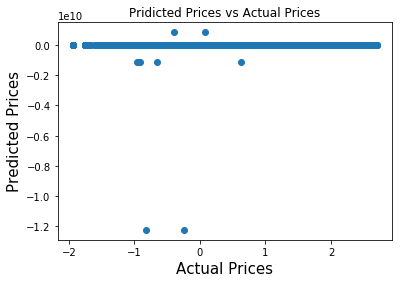

In [48]:
plt.scatter(y_test, lm.predict(X_test))
plt.title("Pridicted Prices vs Actual Prices")
plt.ylabel("Predicted Prices", fontsize=15)
plt.xlabel("Actual Prices", fontsize=15)

**linear regression on non-scaled dataframe**

In [49]:
model_scores = {}

In [50]:
ml_df_o_noprice = ml_df_o.drop('price', axis=1)

In [51]:
X = ml_df_o_noprice
y = ml_df_o.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

In [52]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [53]:
print('training_score = ', lm.score(X_train, y_train))
print('testing_score = ', lm.score(X_test, y_test))

model_scores['linear_regression']={'train':lm.score(X_train, y_train), 'test':lm.score(X_test, y_test)}

training_score =  0.6494271315730508
testing_score =  0.6418396228055516


Text(0.5,0,'Actual Prices')

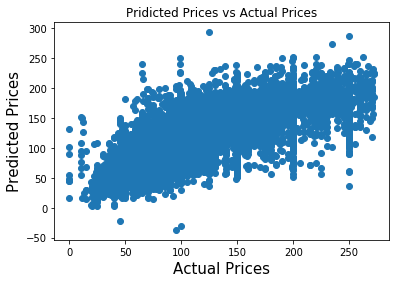

In [54]:
plt.scatter(y_test, lm.predict(X_test))
plt.title("Pridicted Prices vs Actual Prices")
plt.ylabel("Predicted Prices", fontsize=15)
plt.xlabel("Actual Prices", fontsize=15)

**Decision Tree**

In [55]:
X = ml_df_o_noprice
y = ml_df_o.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

In [56]:
from sklearn import tree
decision_tree = tree.DecisionTreeRegressor(max_features='sqrt', min_impurity_decrease=0.5)
tree_model = decision_tree.fit(X_train, y_train)

In [57]:
print('training score = ', tree_model.score(X_train,y_train))
print('testing score = ', tree_model.score(X_test,y_test))

model_scores['decision_tree']={'train':tree_model.score(X_train, y_train), 'test':tree_model.score(X_test, y_test)}

training score =  0.508323535037808
testing score =  0.49567899136609544


Text(0.5,0,'Actual Prices')

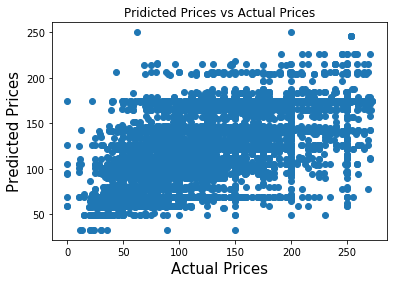

In [58]:
plt.scatter(y_test, tree_model.predict(X_test))
plt.title("Pridicted Prices vs Actual Prices")
plt.ylabel("Predicted Prices", fontsize=15)
plt.xlabel("Actual Prices", fontsize=15)

**Random Forest**

In [59]:
X = ml_df_o_noprice
y = ml_df_o.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

In [60]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor(n_estimators=50, max_features='sqrt')
rf_model = random_forest.fit(X_train, y_train)

In [61]:
print('training score = ', rf_model.score(X_train,y_train))
print('testing score = ', rf_model.score(X_test,y_test))

model_scores['random_forest']={'train':rf_model.score(X_train, y_train), 'test':rf_model.score(X_test, y_test)}

training score =  0.9508520674097798
testing score =  0.6706607263074518


Text(0.5,0,'Actual Prices')

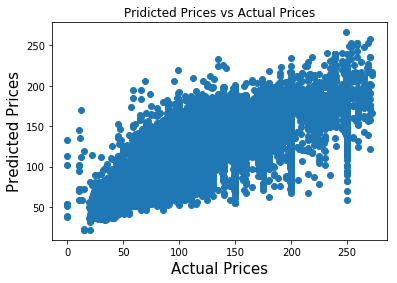

In [62]:
plt.scatter(y_test, rf_model.predict(X_test))
plt.title("Pridicted Prices vs Actual Prices")
plt.ylabel("Predicted Prices", fontsize=15)
plt.xlabel("Actual Prices", fontsize=15)

**Gradient Boosting**

In [63]:
X = ml_df_o_noprice
y = ml_df_o.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

In [64]:
from sklearn.ensemble import GradientBoostingRegressor
gradient_boost = GradientBoostingRegressor()
gb_model = gradient_boost.fit(X_train, y_train)

In [65]:
print('training score = ', gb_model.score(X_train, y_train))
print('testing score = ', gb_model.score(X_test, y_test))

model_scores['gradient_boost']={'train':gb_model.score(X_train, y_train), 'test':gb_model.score(X_test, y_test)}

training score =  0.6799078804090641
testing score =  0.6754183089403711


Text(0.5,0,'Actual Prices')

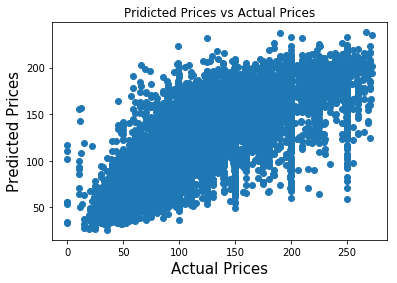

In [66]:
plt.scatter(y_test, gb_model.predict(X_test))
plt.title("Pridicted Prices vs Actual Prices")
plt.ylabel("Predicted Prices", fontsize=15)
plt.xlabel("Actual Prices", fontsize=15)

**Adaboost regression**

In [67]:
X = ml_df_o_noprice
y = ml_df_o.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

In [68]:
from sklearn.ensemble import AdaBoostRegressor
ada_boost = AdaBoostRegressor()
ada_model = ada_boost.fit(X_train, y_train)

In [69]:
print('training score = ', ada_model.score(X_train, y_train))
print('testing score = ', ada_model.score(X_test, y_test))

model_scores['adaboost']={'train':ada_model.score(X_train, y_train), 'test':ada_model.score(X_test, y_test)}

training score =  0.29329182645872076
testing score =  0.27403630738962137


Text(0.5,0,'Actual Prices')

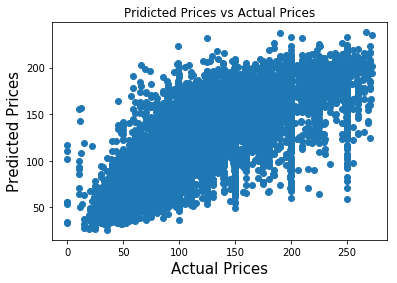

In [70]:
plt.scatter(y_test, gb_model.predict(X_test))
plt.title("Pridicted Prices vs Actual Prices")
plt.ylabel("Predicted Prices", fontsize=15)
plt.xlabel("Actual Prices", fontsize=15)

**KNN regression**

In [71]:
X = ml_df_o_noprice
y = ml_df_o.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

In [72]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
knn_model = knn.fit(X_train, y_train)

In [73]:
print('training score = ', knn_model.score(X_train, y_train))
print('testing score = ', knn_model.score(X_test, y_test))

model_scores['KNN']={'train':knn_model.score(X_train, y_train), 'test':knn_model.score(X_test, y_test)}

training score =  0.5202360140372473
testing score =  0.291430791412678


Text(0.5,0,'Actual Prices')

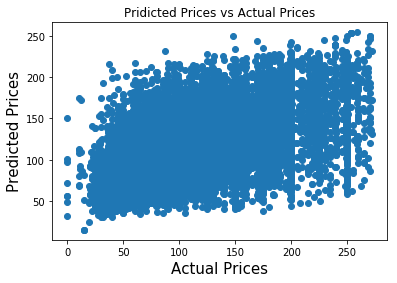

In [74]:
plt.scatter(y_test, knn_model.predict(X_test))
plt.title("Pridicted Prices vs Actual Prices")
plt.ylabel("Predicted Prices", fontsize=15)
plt.xlabel("Actual Prices", fontsize=15)

**XG Boost**

In [75]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

ml_df_o_noprice.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in ml_df_o_noprice.columns.values]

X = ml_df_o_noprice
y = ml_df_o.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

In [76]:
import xgboost as xgb



xg_reg = xgb.XGBRegressor(objective ='reg:linear')
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [77]:
print('training score = ', xg_reg.score(X_train, y_train))
print('testing score = ', xg_reg.score(X_test, y_test))

model_scores['XGboost']={'train':xg_reg.score(X_train, y_train), 'test':xg_reg.score(X_test, y_test)}

training score =  0.6789886430547732
testing score =  0.6752471318648172


In [78]:
model_scores

{'linear_regression': {'train': 0.6494271315730508,
  'test': 0.6418396228055516},
 'decision_tree': {'train': 0.508323535037808, 'test': 0.49567899136609544},
 'random_forest': {'train': 0.9508520674097798, 'test': 0.6706607263074518},
 'gradient_boost': {'train': 0.6799078804090641, 'test': 0.6754183089403711},
 'adaboost': {'train': 0.29329182645872076, 'test': 0.27403630738962137},
 'KNN': {'train': 0.5202360140372473, 'test': 0.291430791412678},
 'XGboost': {'train': 0.6789886430547732, 'test': 0.6752471318648172}}

In [79]:
models = pd.DataFrame(model_scores)
models = models.T
models

,test,train
linear_regression,0.641840,0.649427
decision_tree,0.495679,0.508324
random_forest,0.670661,0.950852
gradient_boost,0.675418,0.679908
adaboost,0.274036,0.293292
KNN,0.291431,0.520236
XGboost,0.675247,0.678989


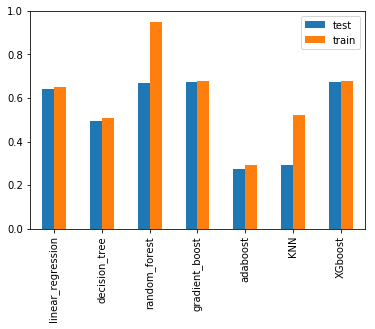

In [80]:
models.plot(kind='bar')

**Feature selection**

In [81]:
X = ml_df_o_noprice
y = ml_df_o.price

In [82]:
from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(lm, threshold='median', prefit=True , max_features=50)
X_new = selector.transform(X)
X_new.shape

(43514, 50)

In [83]:
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_new, y, test_size=0.3, random_state=6)

lm.fit(X_train_sel, y_train_sel)

print('training_score after feature selection = ', lm.score(X_train_sel, y_train_sel))
print('testing_score after feature selection = ', lm.score(X_test_sel, y_test_sel))

training_score after feature selection =  0.03539432254032171
testing_score after feature selection =  0.03062175082111418


*****

### Linear SVM regression

Taking too long!

In [84]:
#from sklearn.svm import SVR

#svr_linear = SVR(kernel='linear')

In [85]:
#svr_model = svr_linear.fit(X_train, y_train)

In [86]:
#svr_pred = svr_model.predict(X_test)